In [1]:
# Import PuLP modeler functions
!pip install pulp
from pulp import *
import random

In [9]:
nItems = 20
print("Number of Items:",nItems)
Items = range(nItems)
ItemPairs = list(itertools.permutations(Items,2))

random.seed( 15 )

height = {x: random.randint(1,10) for x in range(nItems)}
width = {x: random.randint(1,10) for x in range(nItems)}
itemValue = {x: height[x] * random.randint(0,3) + width[x] * random.randint(0,5) for x in range(nItems)}

#W = int(nItems**(1/2) * 10);
H = 10;

prob = LpProblem("Strip Packing",LpMinimize)

# The problem variables are created
W = LpVariable("width unrolled")

packed = LpVariable.dicts("packed",(Items),1,1,LpInteger)
rotated = LpVariable.dicts("rotated",(Items),0,1,LpInteger)
x_origin = LpVariable.dicts("x_origin",(Items),0,10000)
y_origin = LpVariable.dicts("y_origin",(Items),0,H)

x_overlap_right = LpVariable.dicts("x_overlap_right",(ItemPairs),0,1,LpInteger)
x_overlap_left = LpVariable.dicts("x_overlap_left",(ItemPairs),0,1,LpInteger)
y_overlap_above = LpVariable.dicts("y_overlap_above",(ItemPairs),0,1,LpInteger)
y_overlap_below = LpVariable.dicts("y_overlap_below",(ItemPairs),0,1,LpInteger)

# The arbitrary objective function is added
prob += W, "Objective Function"

for (i,j) in ItemPairs:
    prob += x_overlap_right[i,j] + x_overlap_left[i,j] >= 1
    prob += y_overlap_above[i,j] + y_overlap_below[i,j] >= 1
    prob += x_overlap_left[j,i] + x_overlap_left[i,j] >= 1
    prob += x_overlap_right[j,i] + x_overlap_right[i,j] >= 1
    prob += y_overlap_above[j,i] + y_overlap_above[i,j] >= 1
    prob += y_overlap_below[j,i] + y_overlap_below[i,j] >= 1
    prob += x_origin[j] - x_origin[i] - (1-rotated[i])*width[i] - rotated[i] * height[i] + x_overlap_right[i,j] * 1000 >= 0, "overlap right %s %s" %(i,j)
    prob += x_origin[j] + (1-rotated[j])*width[j] + rotated[j]*height[j] - x_origin[i] - x_overlap_left[i,j] * 1000 <= 0, "overlap left %s %s" %(i,j)
    prob += y_origin[j] - y_origin[i] - (1-rotated[i]) * height[i] - rotated[i] * width[i] + y_overlap_above[i,j] * 1000 >= 0, "overlap above %s %s" %(i,j)
    prob += y_origin[j] + (1-rotated[j])*height[j] + rotated[j]*width[j] - y_origin[i] - y_overlap_below[i,j] * 1000 <= 0, "overlap below %s %s" %(i,j)
    prob += x_overlap_right[i,j] + x_overlap_left[i,j] + y_overlap_below[i,j] + y_overlap_above[i,j] <= 3 + 3*((1-packed[i])+(1-packed[j])), "no overlap %s %s" %(i,j)

for i in Items:
    prob += x_origin[i] + (1-rotated[i])*width[i] + rotated[i]* height[i] <= W + (1-packed[i]) * 1000 , "maxWidth %i" %i
    prob += y_origin[i] + (1-rotated[i])*height[i] + rotated[i] * width[i] <= H + (1-packed[i]) * 1000, "maxHeight %i" %i

prob += W*H >= lpSum([packed[i] * width[i] * height[i] for i in Items]), "maxArea"

prob.solve(PULP_CBC_CMD(maxSeconds=30))
#prob.solve(pulp.GUROBI_CMD(options=[("TimeLimit", 15)]))
#prob.solve(PULP_CBC_CMD(fracGap = 0.1))
#prob.solve(pulp.GUROBI_CMD(options=[("MIPgap", 0.05)]))
## Print the value of the objective
print("Objective = %f" % value(prob.objective))


Number of Items: 20
Objective = 63.000000


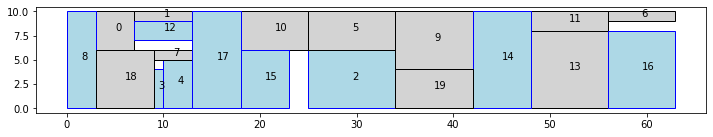

In [12]:
## import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 12]

plt.axes()
rectangle = plt.Rectangle((0,0), W, H, fc='white',ec="white")

# Create a Rectangle patch
for i in Items:
    if rotated[i].varValue == 0:
        rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),width[i],height[i],edgecolor='black',facecolor='lightgray')
        plt.gca().add_patch(rect)
        centerx = width[i]  /2 + x_origin[i].varValue
        centery = height[i] /2 + y_origin[i].varValue 
        plt.text(centerx, centery,'%s'%i)
    else:
        rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),height[i],width[i],edgecolor='blue',facecolor='lightblue')
        plt.gca().add_patch(rect)
        centerx = height[i]  /2 + x_origin[i].varValue
        centery = width[i] /2 + y_origin[i].varValue 
        plt.text(centerx, centery,'%s'%i)        
plt.axis('scaled')
plt.show()